In [61]:

#Install dependencies
!pip install kaggle


In [62]:

!pwd



/content


In [63]:

#Getting Kaggle.JSON file from Google Drive
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [64]:

!mkdir -p ~/.kaggle
!cp '/content/drive/My Drive/kaggle.json' ~/.kaggle/
#Changing permission
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat '/content/drive/My Drive/kaggle.json': No such file or directory


In [66]:
!kaggle datasets list


ref                                                           title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ruchikakumbhar/obesity-prediction                             Obesity Prediction Dataset                         58KB  2025-01-14 05:31:18           1234         27  1.0              
anandshaw2001/netflix-movies-and-tv-shows                     Netflix Movies and TV Shows                         1MB  2025-01-03 10:33:01           4277        118  1.0              
raedaddala/top-500-600-movies-of-each-year-from-1960-to-2024  30,000+ Movies, 60+ Years of Data, Rich Metadata    4MB  2025-01-05 17:17:05            899         28  1.0              
preetigupta004/cancer-issue                                   Cancer issue      

In [68]:
#Download Dataset

!kaggle competitions download -c digit-recognizer


 33% 5.00M/15.3M [00:00<00:00, 41.8MB/s]
100% 15.3M/15.3M [00:00<00:00, 78.4MB/s]


In [70]:

!unzip '/content/digit-recognizer.zip'

Archive:  /content/digit-recognizer.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [71]:

!rm -rf test.csv.zip
!rm -rf train.csv.zip


In [72]:
import tensorflow as tf
print(tf.__version__)

2.17.1


In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

In [74]:
digit_train = pd.read_csv('/content/train.csv', on_bad_lines='skip')
digit_test = pd.read_csv('/content/test.csv', on_bad_lines='skip')

In [75]:
#Checking train Null values

print("Train_data_Null Values",digit_train.isnull().sum())

#Checking Test null value
print("Test_data_Null Values",digit_test.isnull().sum())


Train_data_Null Values label       0
pixel0      0
pixel1      0
pixel2      0
pixel3      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 785, dtype: int64
Test_data_Null Values pixel0      0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 784, dtype: int64


In [76]:
#Train_Datset_duplicates
print("Train Dataset_Duplicates",digit_train.duplicated().sum())

#Test_Dataset_duplicates
print("Test Dataset_Duplicates",digit_test.duplicated().sum())


Train Dataset_Duplicates 0
Test Dataset_Duplicates 0


In [77]:
digit_train['label'].unique()

array([1, 0, 4, 7, 3, 5, 8, 9, 2, 6])

In [78]:
print("Train_data Shape",digit_train.shape)
print("Test_data Shape",digit_test.shape)

Train_data Shape (42000, 785)
Test_data Shape (28000, 784)


Text(0.5, 1.0, 'Distribution of labels in training set')

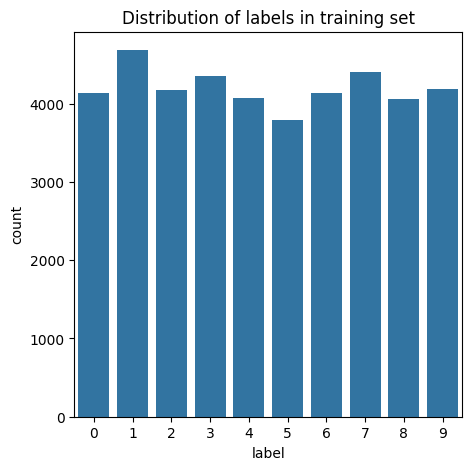

In [79]:
# Figure size
plt.figure(figsize=(5,5))

# Countplot
sns.countplot(x='label', data=digit_train)
plt.title('Distribution of labels in training set')

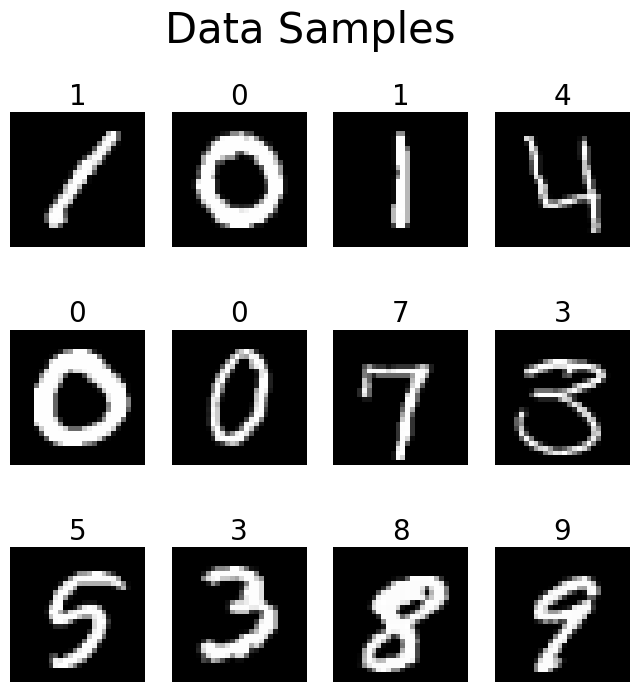

In [80]:
# Showing an data samples using count plot

fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(8,8))
i = 0
for row in range(3):
  for col in range(4):
    axs[row][col].imshow(digit_train.iloc[i, 1:].values.reshape(28,28), cmap='gray')
    axs[row][col].set_title(str(digit_train.iloc[i, 0]), fontsize=20)
    axs[row][col].axis('off')
    i+=1

plt.suptitle('Data Samples', fontsize=30)
plt.show()


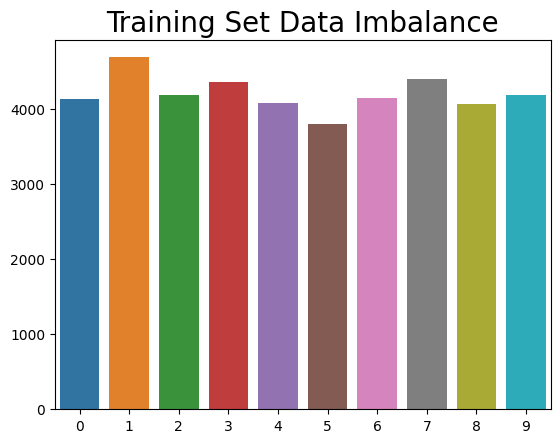

In [81]:
# Graph for training data imbalance

train_samplesize = pd.DataFrame({str(x): digit_train['label'].value_counts()[x] for x in range(10)}, index=[0])

sns.barplot(data=train_samplesize).set_title('Training Set Data Imbalance', fontsize=20)
plt.show()

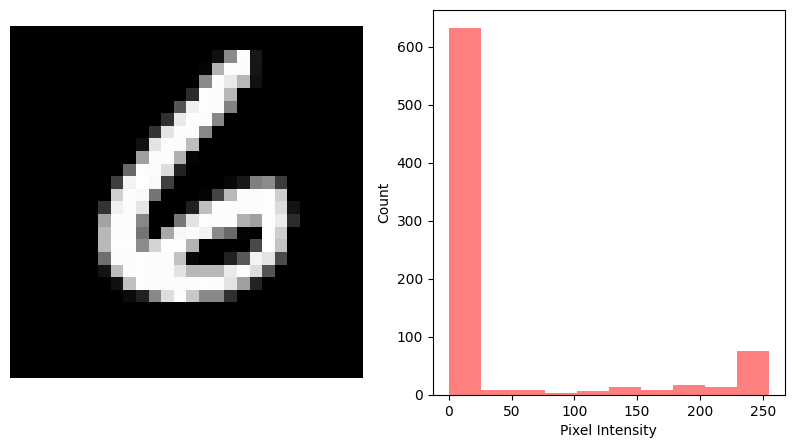

In [82]:
# plotting histogram for shwoing count and pixcel intensity
def plotHist(img):
  img = digit_train.iloc[img, 1:].values.reshape(28,28)
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.imshow(img, cmap='gray')
  plt.axis('off')
  histo = plt.subplot(1,2,2)
  histo.set_ylabel('Count')
  histo.set_xlabel('Pixel Intensity')
  plt.hist(img.flatten(), bins=10, lw=0, color='r', alpha=0.5)

plotHist(202)

In [83]:

train_y=digit_train['label'].astype('float32')
train_x=digit_train.drop(['label'],axis=1).astype('int32')
test_x=digit_test.astype('float32')
train_y.shape,train_x.shape,test_x.shape

((42000,), (42000, 784), (28000, 784))

In [84]:

train_x = train_x.values.reshape(-1,28,28,1)
train_x = train_x / 255.0
test_x = test_x.values.reshape(-1,28,28,1)
test_x = test_x / 255.0
train_x.shape, test_x.shape

((42000, 28, 28, 1), (28000, 28, 28, 1))

In [85]:
#One Hot Encoding
train_y = tf.keras.utils.to_categorical(train_y,10)
train_y.shape

(42000, 10)

In [86]:
#Printing original labels of top 5 rows

print(digit_train['label'].head())


0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64


In [87]:

#One hot encoding of the same labels

print(train_y[0:5,:])

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [88]:

#Defining the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32,(3,3),activation = 'relu', input_shape=(28,28,1)),
  tf.keras.layers.Conv2D(32,(3,3),activation = 'relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(64,(3,3),activation = 'relu',padding = 'Same'),
  tf.keras.layers.Conv2D(64,(3,3),activation = 'relu',padding = 'Same'),
  tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2,2)),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Conv2D(64,(3,3),activation = 'relu',padding = 'Same'),
  tf.keras.layers.Conv2D(64,(3,3),activation = 'relu',padding = 'Same'),
  tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2,2)),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  #tf.keras.layers.Dropout(0.50),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.50),
  tf.keras.layers.Dense(10, activation='softmax')
])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 6, 6, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 6, 6, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         147,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 354,922 (1.35 MB)

 Trainable params: 354,922 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

In [89]:

#Defining the callback function to stop our training once the acceptable accuracy is reached
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if(logs.get('accuracy') > 0.999):
                print("\nReached 99.9% accuracy so cancelling training!")
                self.model.stop_training = True

callbacks = myCallback()

In [90]:


#Compiling and model training with batch size = 50, epochs = 20, and optimizer = adam
Optimizer = tf.keras.optimizers.Adam(
            learning_rate=0.0005,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-07,
            name='Adam'
)
model.compile(optimizer=Optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_x, train_y, batch_size = 50, epochs = 18, callbacks=[callbacks])

Epoch 1/18
840/840 ━━━━━━━━━━━━━━━━━━━━ 163s 188ms/step - accuracy: 0.7379 - loss: 0.7613
Epoch 2/18
840/840 ━━━━━━━━━━━━━━━━━━━━ 206s 194ms/step - accuracy: 0.9753 - loss: 0.0849
Epoch 3/18
840/840 ━━━━━━━━━━━━━━━━━━━━ 194s 185ms/step - accuracy: 0.9827 - loss: 0.0590
Epoch 4/18
840/840 ━━━━━━━━━━━━━━━━━━━━ 203s 186ms/step - accuracy: 0.9864 - loss: 0.0469
Epoch 5/18
840/840 ━━━━━━━━━━━━━━━━━━━━ 152s 181ms/step - accuracy: 0.9891 - loss: 0.0387
Epoch 6/18
840/840 ━━━━━━━━━━━━━━━━━━━━ 199s 177ms/step - accuracy: 0.9896 - loss: 0.0357
Epoch 7/18
840/840 ━━━━━━━━━━━━━━━━━━━━ 149s 177ms/step - accuracy: 0.9913 - loss: 0.0320
Epoch 8/18
840/840 ━━━━━━━━━━━━━━━━━━━━ 152s 181ms/step - accuracy: 0.9924 - loss: 0.0264
Epoch 9/18
840/840 ━━━━━━━━━━━━━━━━━━━━ 202s 180ms/step - accuracy: 0.9923 - loss: 0.0245
Epoch 10/18
840/840 ━━━━━━━━━━━━━━━━━━━━ 152s 181ms/step - accuracy: 0.9938 - loss: 0.0202
Epoch 11/18
840/840 ━━━━━━━━━━━━━━━━━━━━ 206s 185ms/step - accuracy: 0.9940 - loss: 0.0210
Epoch 12

In [91]:

results = model.predict(test_x)

# select the index with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

875/875 ━━━━━━━━━━━━━━━━━━━━ 28s 32ms/step


In [92]:

submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("submission.csv",index=False)

In [93]:
#Submitting the results on Kaggle
!kaggle competitions submit -c digit-recognizer -f submission.csv -m "Message"

100% 208k/208k [00:00<00:00, 512kB/s]
Successfully submitted to Digit Recognizer